# Analyze Gender Pay Gap on Glassdoor

In [69]:
library(tidyverse)
library(repr)
library(gridExtra)

In [70]:
# dataset: https://www.kaggle.com/nilimajauhari/glassdoor-analyze-gender-pay-gap
glassdoor <- read_csv("./Glassdoor_Gender_Pay_Gap.csv")
head(glassdoor)

Parsed with column specification:
cols(
  JobTitle = col_character(),
  Gender = col_character(),
  Age = col_double(),
  PerfEval = col_double(),
  Education = col_character(),
  Dept = col_character(),
  Seniority = col_double(),
  BasePay = col_double(),
  Bonus = col_double()
)



JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Graphic Designer,Female,18,5,College,Operations,2,42363,9938
Software Engineer,Male,21,5,College,Management,5,108476,11128
Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319
IT,Female,20,5,PhD,Operations,4,70890,10126


## data tranformation and wrangling

In [71]:
# convert to factors
glassdoor <- glassdoor %>% mutate_if(is.character, as.factor) 
glassdoor$Seniority <- as.factor(glassdoor$Seniority)
glassdoor$PerfEval <- as.factor(glassdoor$PerfEval)

# add variable: TotalPay
glassdoor$TotalPay <- TotalPay <- glassdoor$BasePay + glassdoor$Bonus

# split into sub dataframes for male and female
male <- glassdoor %>% filter(Gender == "Male")
female <- glassdoor %>% filter(Gender == "Female")

## exploratory data analysis

The distributions of total pay for men and women are both roughly bell-shaped. The distribution of men has slightly higher peak and center towards the right, suggesting a higher pay range overall.

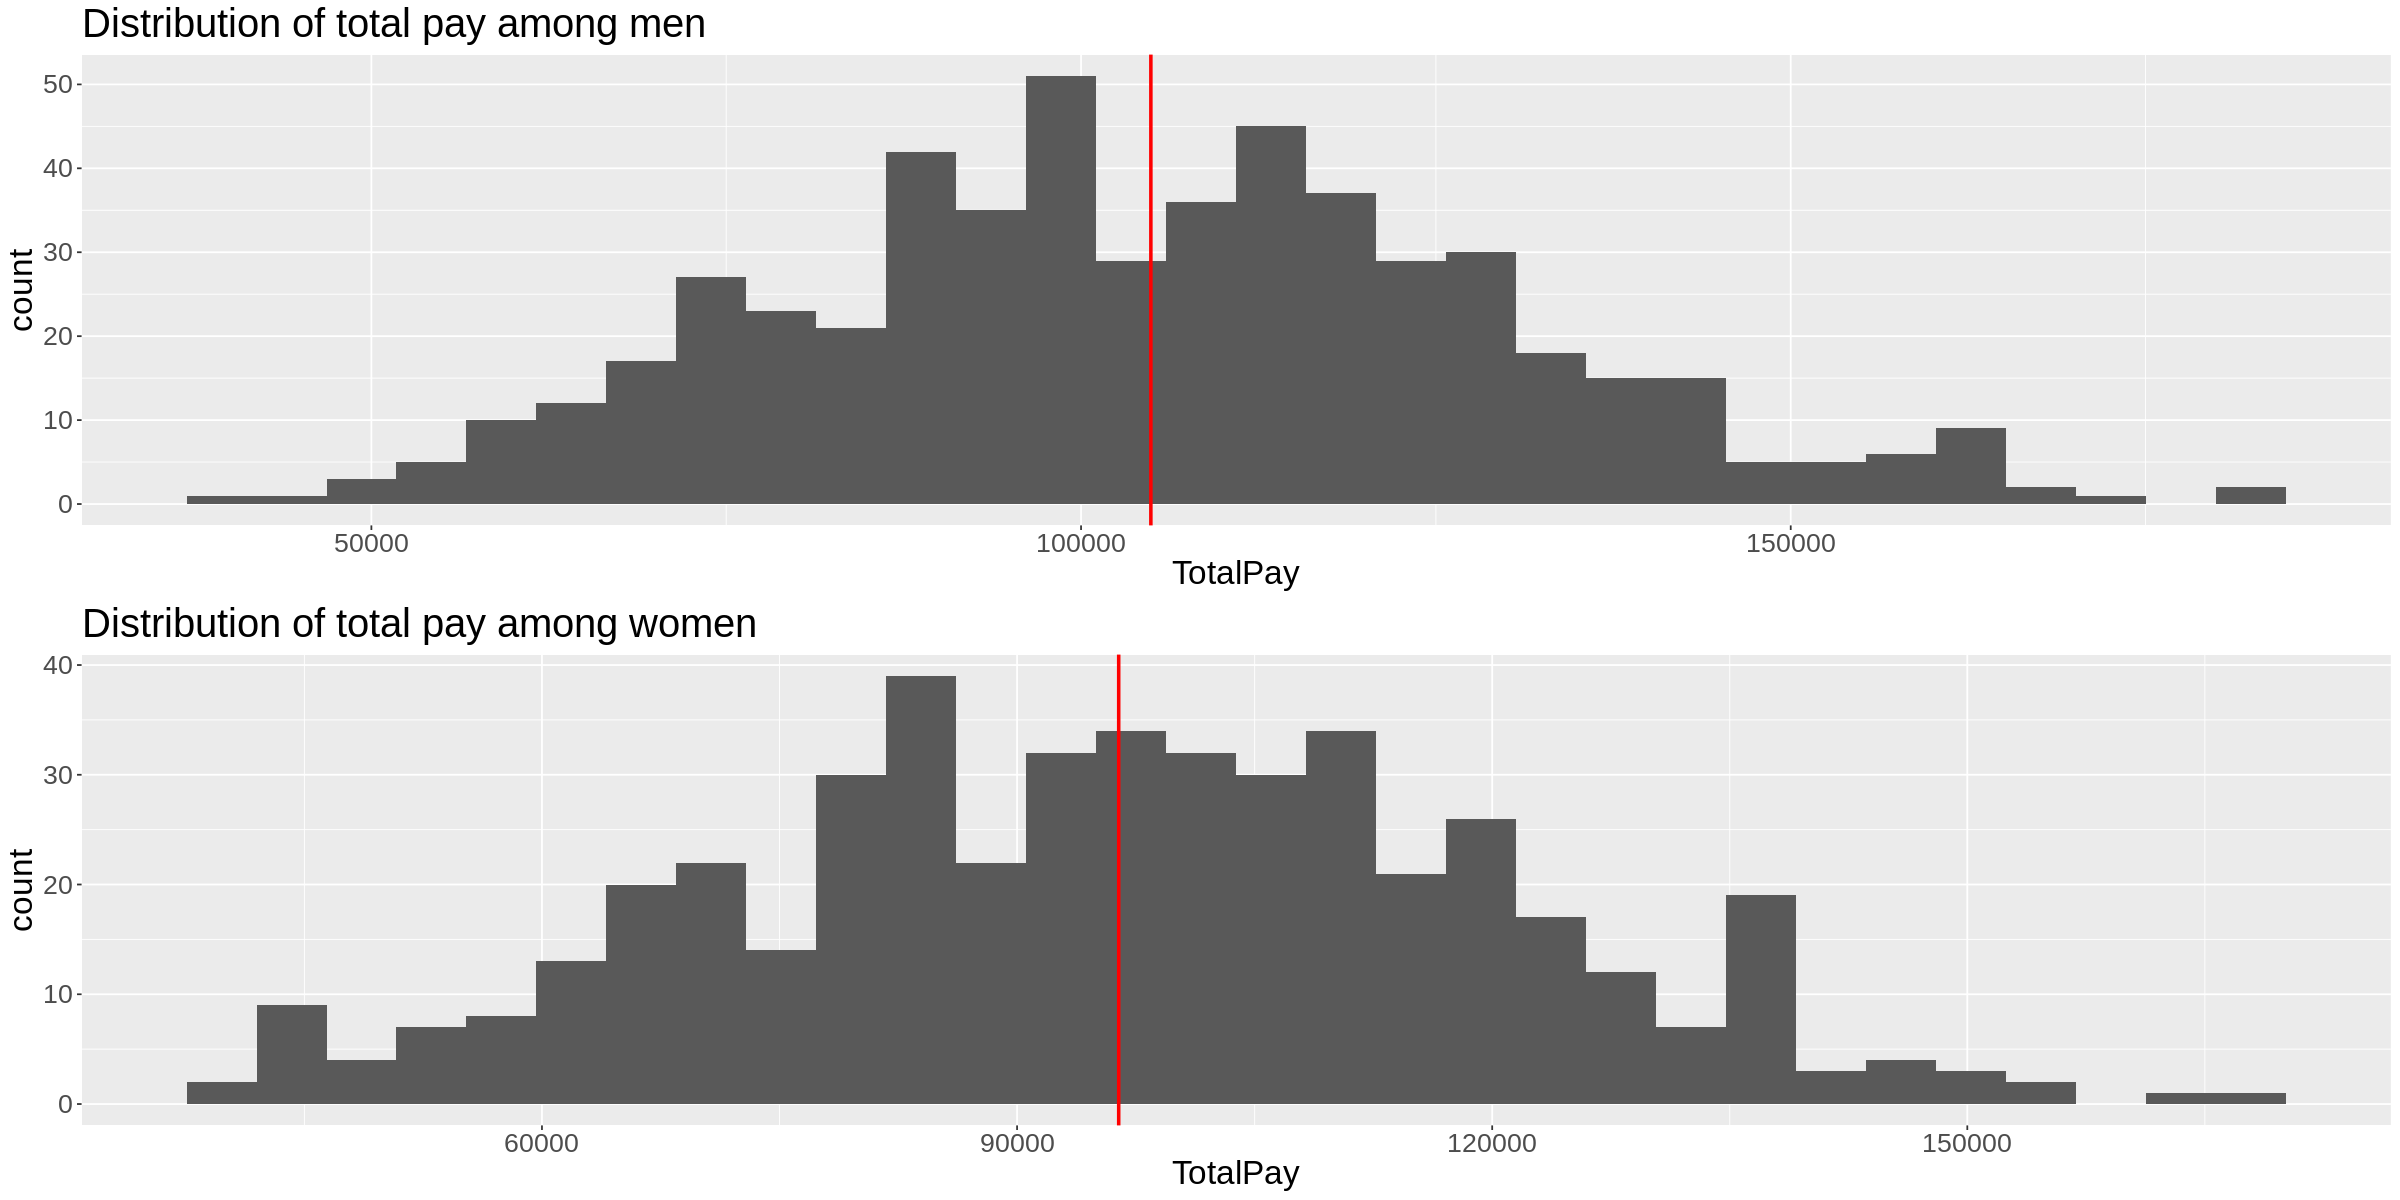

In [72]:
options(repr.plot.width = 20, repr.plot.height = 10)
p <- ggplot(data = male, aes(TotalPay)) + geom_histogram(bins=30) + ggtitle("Distribution of total pay among men") +
            theme(text = element_text(size = 20)) + 
            geom_vline(aes(xintercept = mean(TotalPay)),col='red',size=1)
q <- ggplot(data = female, aes(TotalPay)) + geom_histogram(bins=30) + ggtitle("Distribution of total pay among women") +
            theme(text = element_text(size = 20)) + 
            geom_vline(aes(xintercept = mean(TotalPay)),col='red',size=1)
grid.arrange(p, q, ncol = 1)


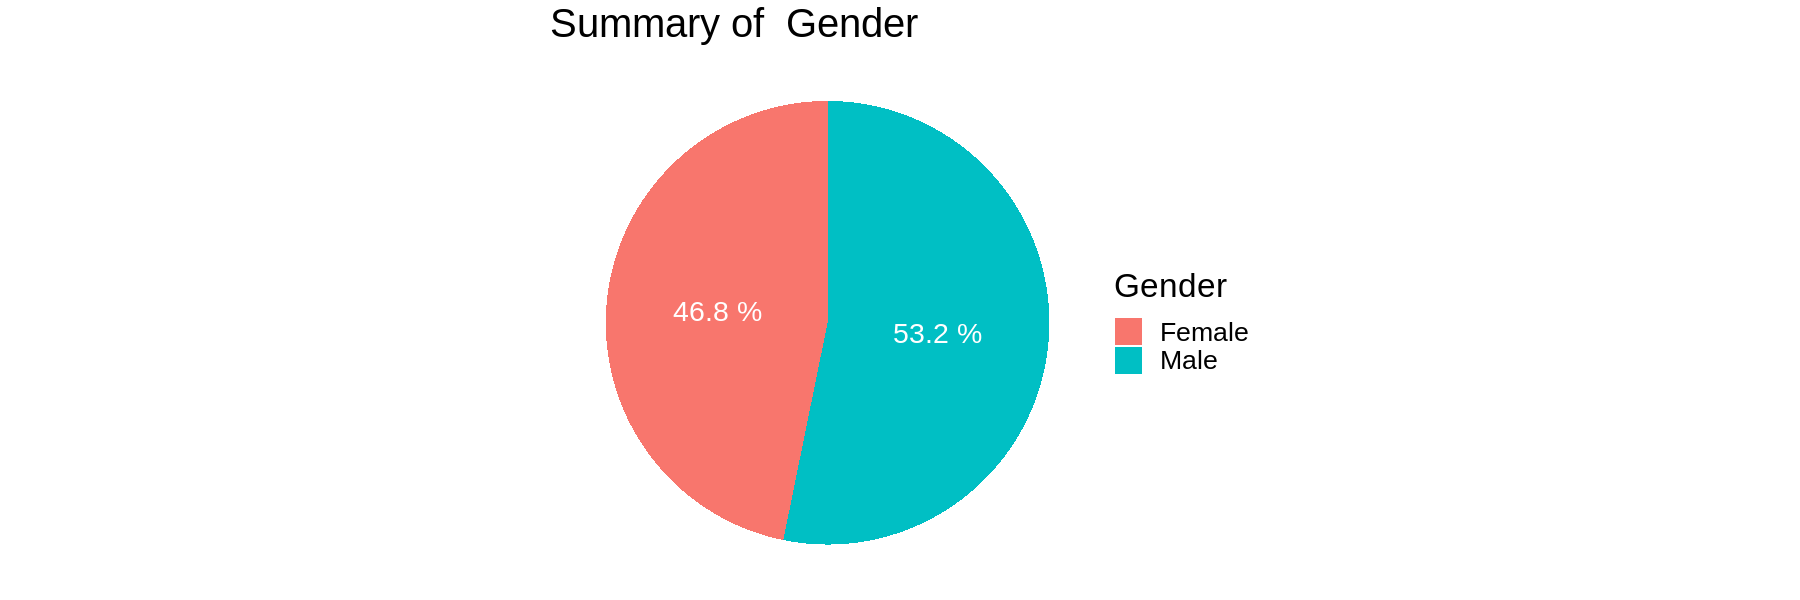

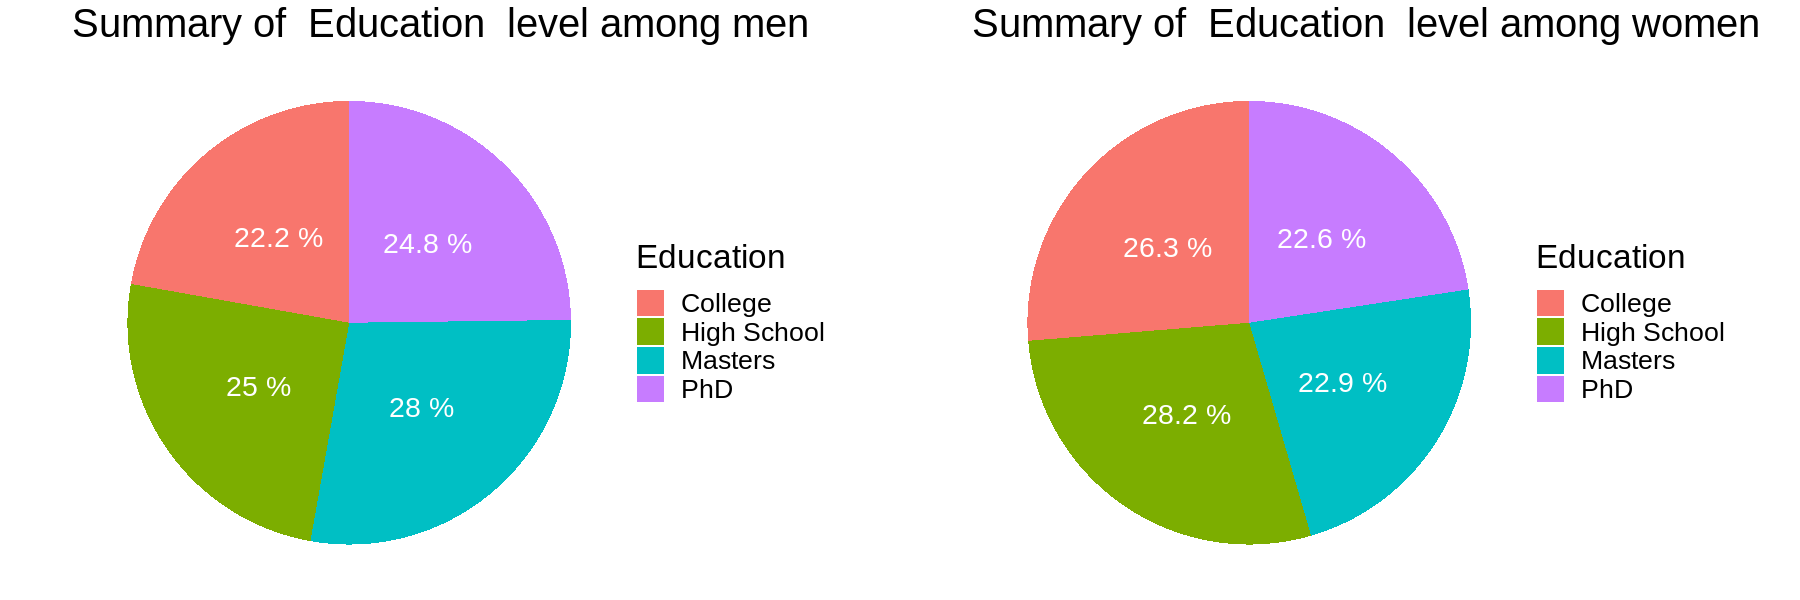

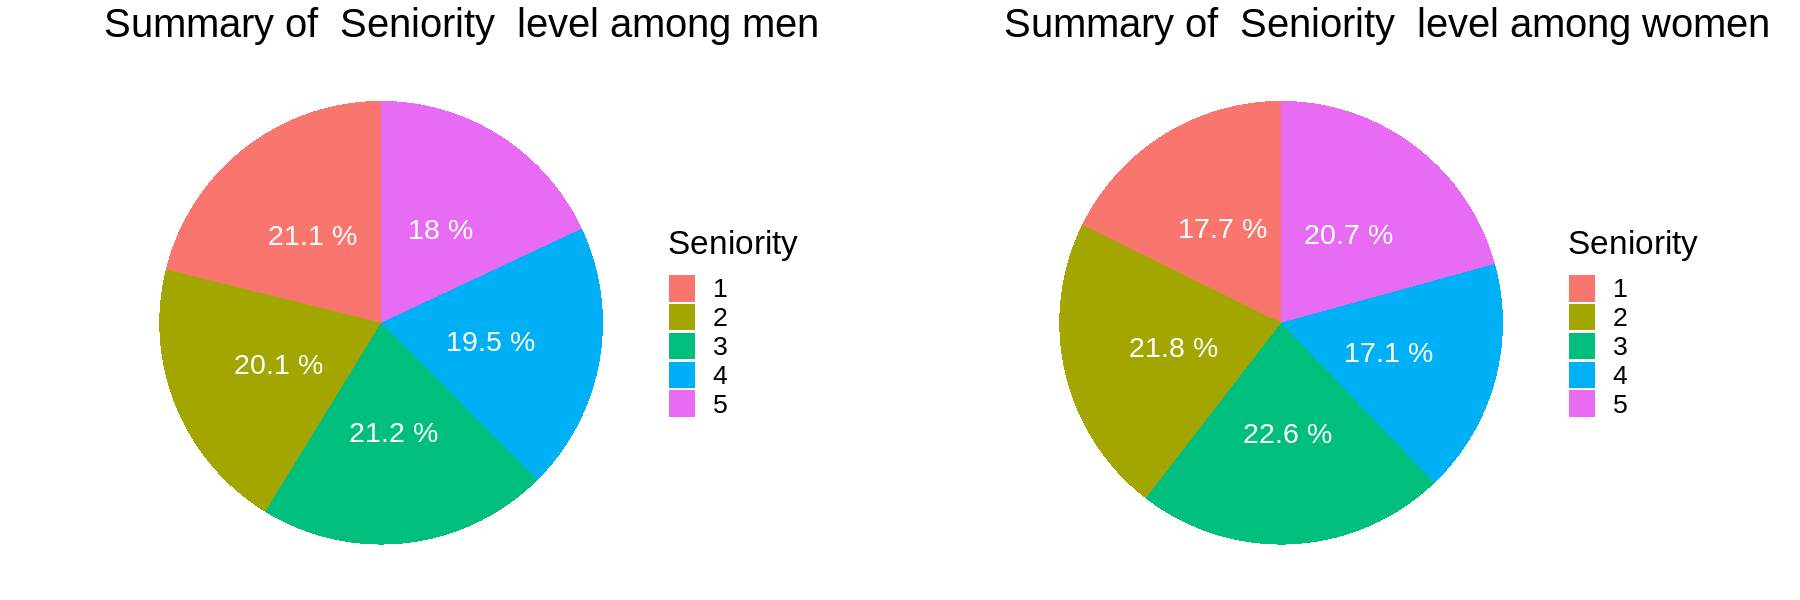

In [73]:
# helper function for making pie charts
MakePieChart <- function(col, df, extra) {
    tbl <- as.data.frame(table(df[[col]]))     
    colnames(tbl) <- c(col, "Count")
    tbl <- tbl %>%
          arrange(desc(tbl)) %>%
          mutate(prop = round(Count / sum(tbl$Count), 3) * 100) %>%
          mutate(ypos = cumsum(prop) - 0.5*prop)

    pie_chart <- ggplot(tbl, aes(x = "", y = prop, fill = .data[[col]])) +
         geom_bar(stat = "identity", width = 1) +
         coord_polar("y", start = 0) +
         geom_text(aes(y = ypos, label = paste(prop, "%")), color = "white", size = 6) +
         theme_void() +     
         theme(text = element_text(size = 20)) +
         ggtitle(paste("Summary of ", col, extra))
    
    return (pie_chart)
}

# pir charts for gender and educaton
options(repr.plot.width = 15, repr.plot.height = 5)
MakePieChart("Gender", glassdoor, "")

grid.arrange(MakePieChart("Education", male, " level among men"), 
             MakePieChart("Education", female, " level among women"), nrow = 1) 

grid.arrange(MakePieChart("Seniority", male, " level among men"), 
             MakePieChart("Seniority", female, " level among women"), nrow = 1) 

From the pie charts above, we can conclude that the dataset captures roughly the same distribution of education and seniority level among the two genders.

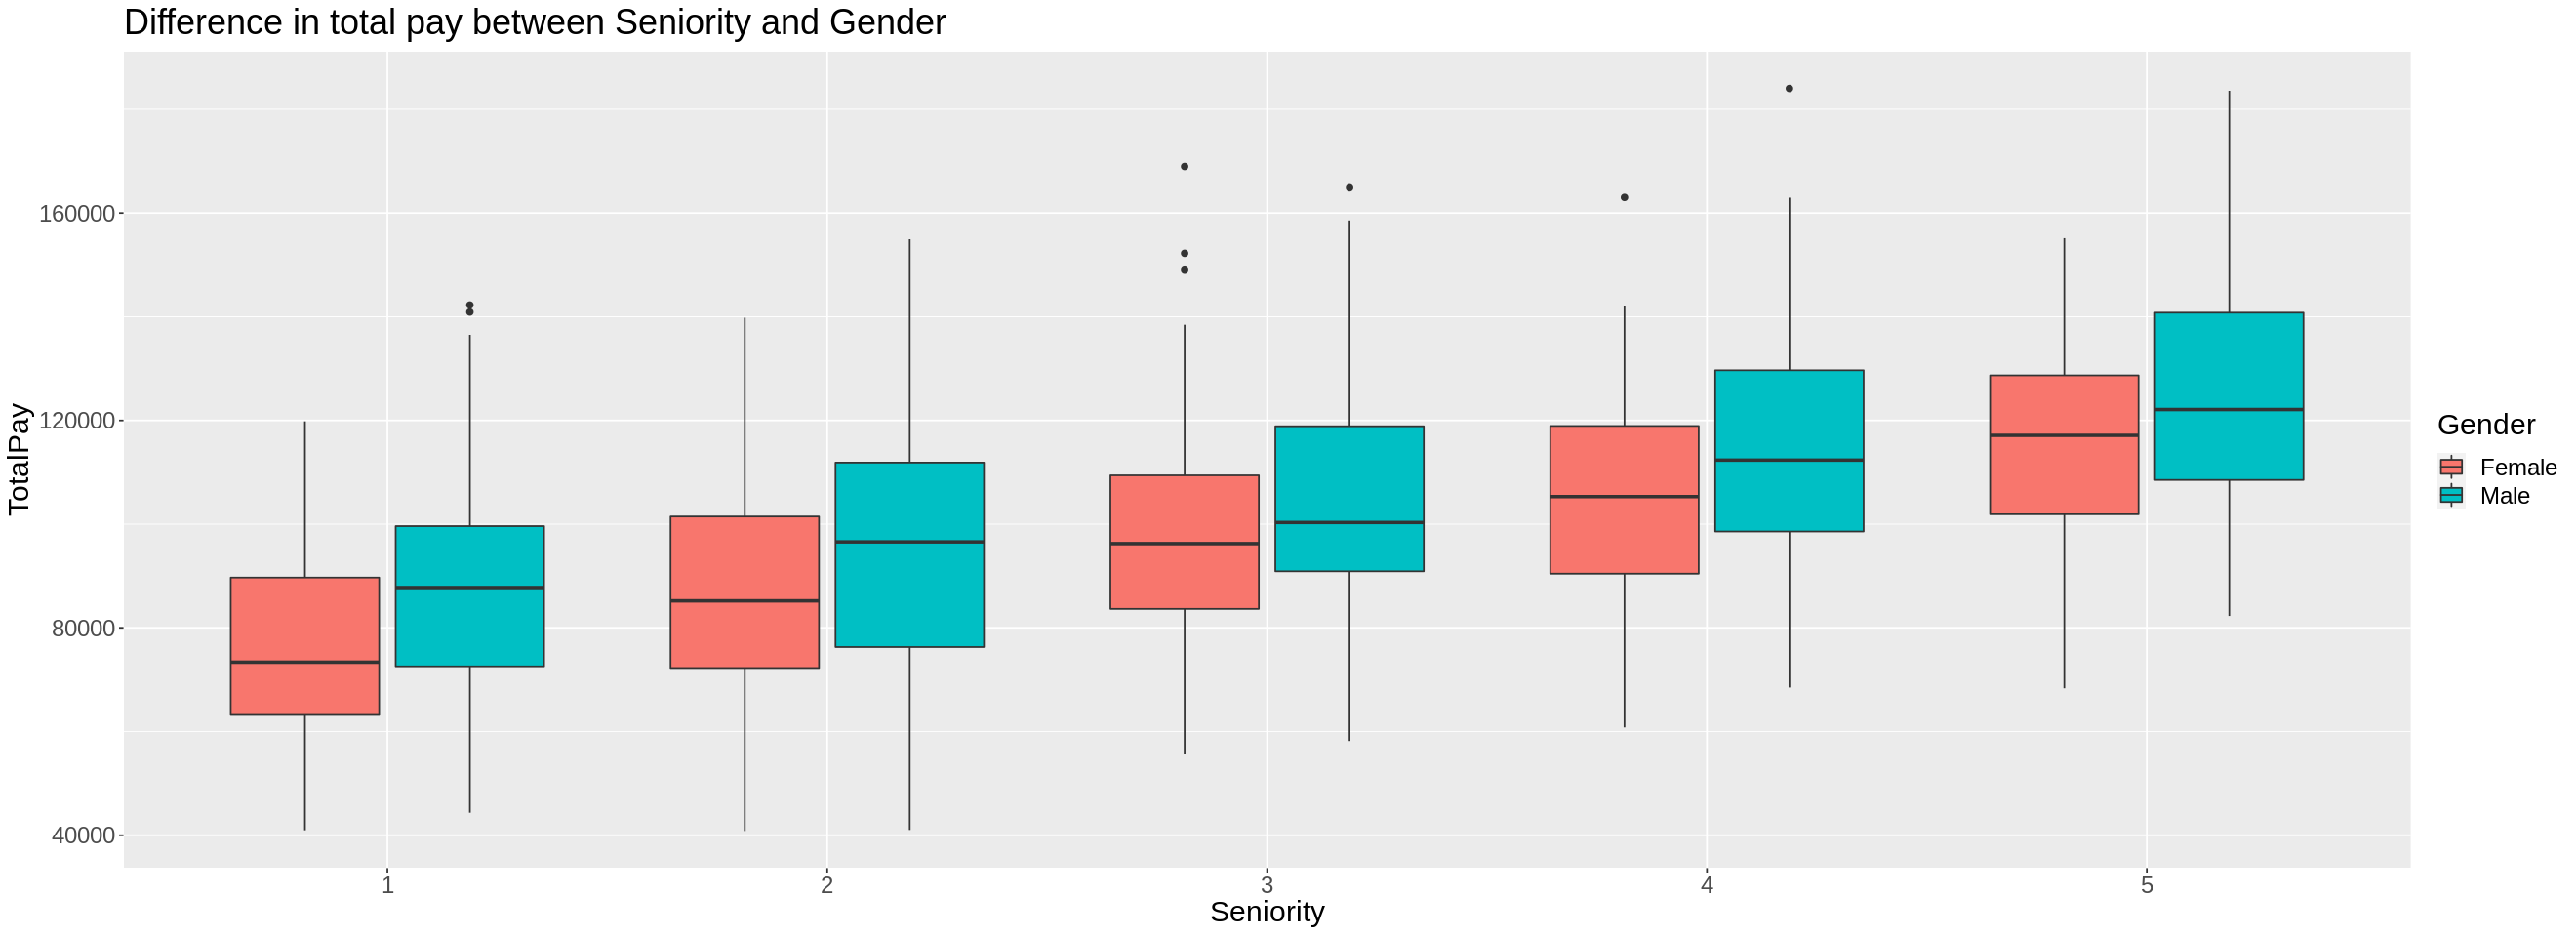

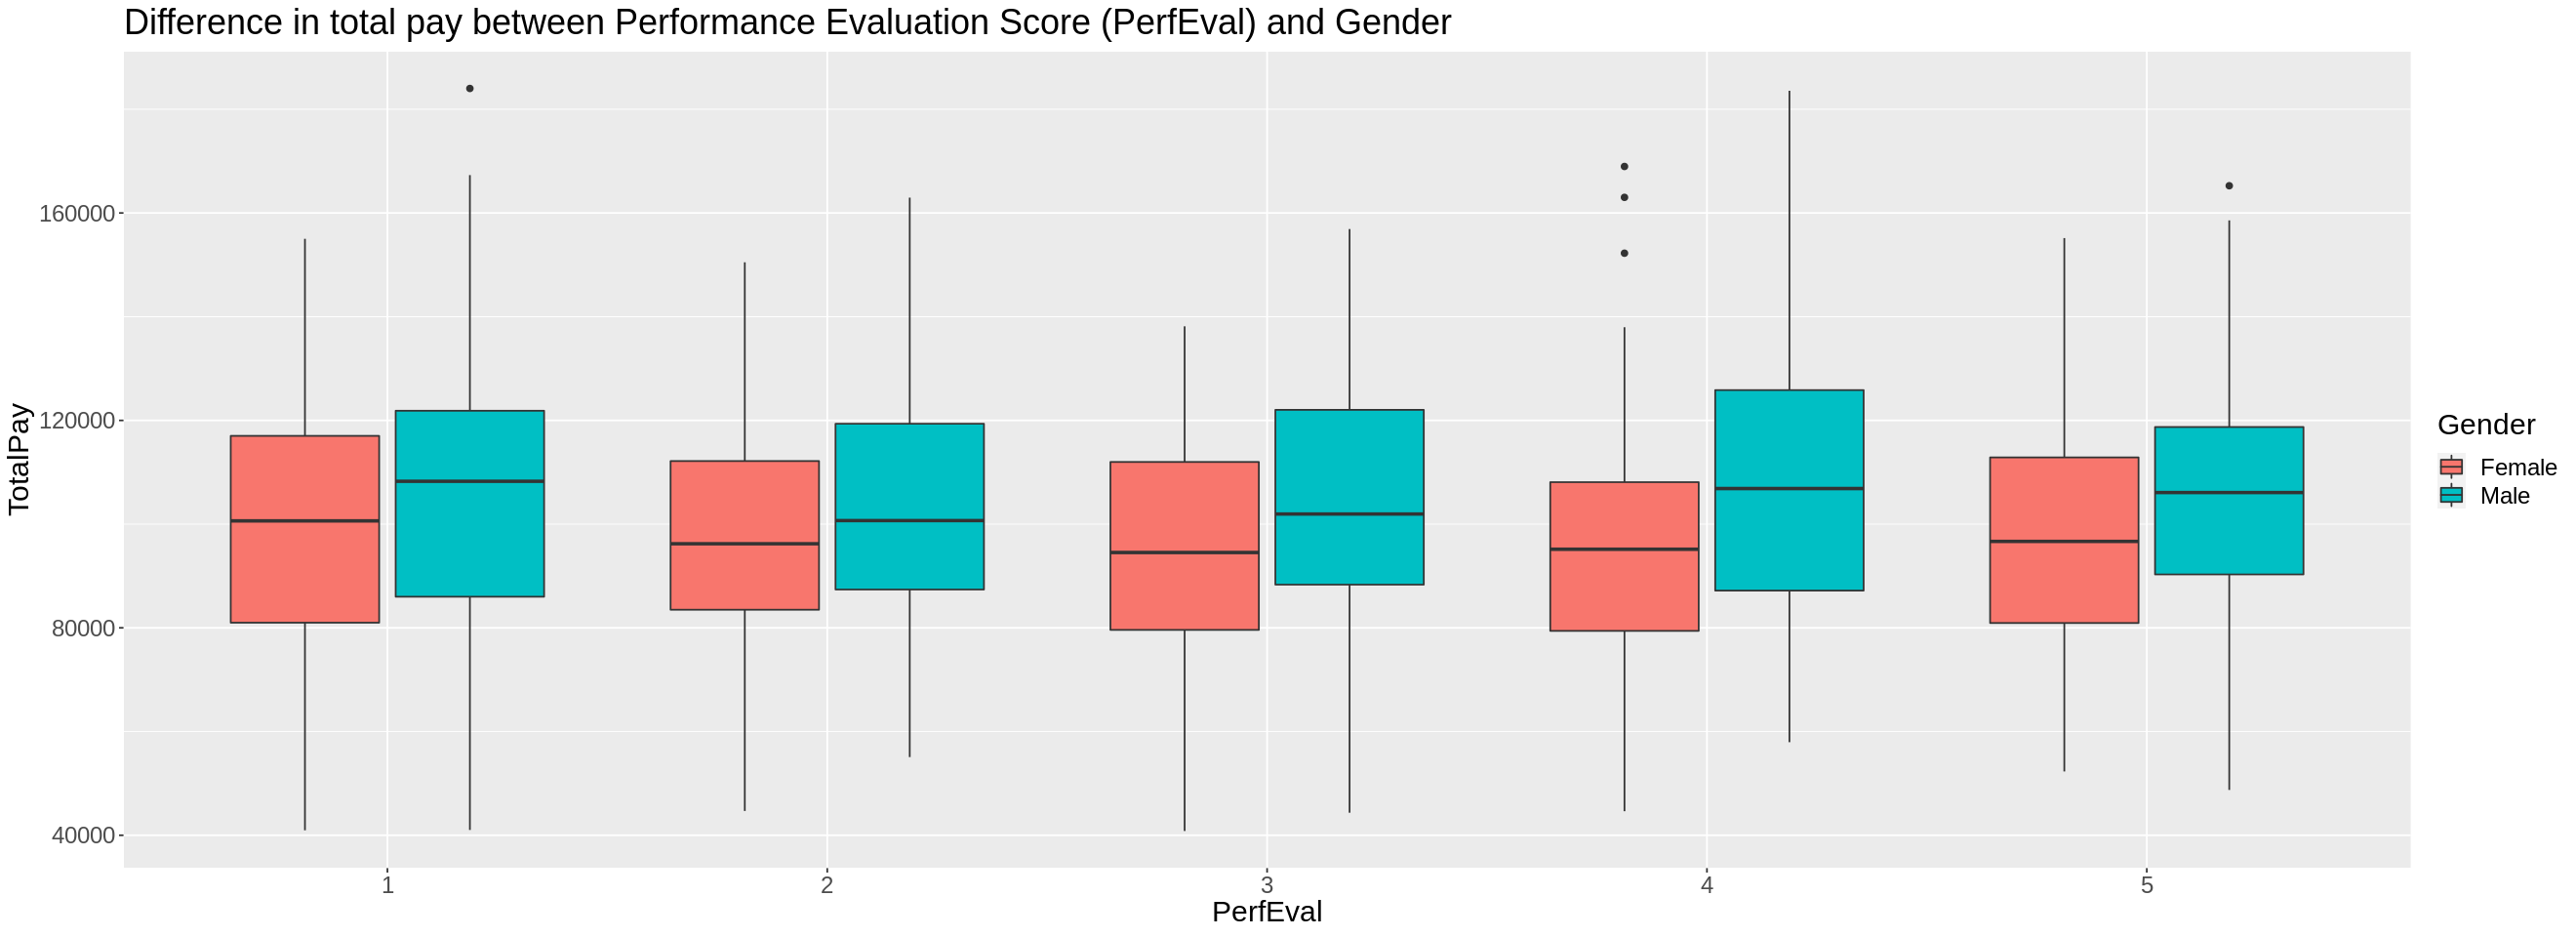

In [87]:
# boxplots for difference in total pay between gender groups
ggplot(glassdoor, aes(x = Seniority, y = TotalPay, fill = Gender)) +
    geom_boxplot() +
    ggtitle("Difference in total pay between Seniority and Gender") +
    theme(text = element_text(size = 18)) 

ggplot(glassdoor, aes(x = PerfEval, y = TotalPay, fill = Gender)) +
    geom_boxplot() +
    ggtitle("Difference in total pay between Performance Evaluation Score (PerfEval) and Gender") +
    theme(text = element_text(size = 18)) 

For the same level of seniority or performance, men generally have a higher pay range, suggesting the existence of gender pay gap overall.  
It is somewhat suprising that the pay range does not seem to increase with Performance Evaluation Score.

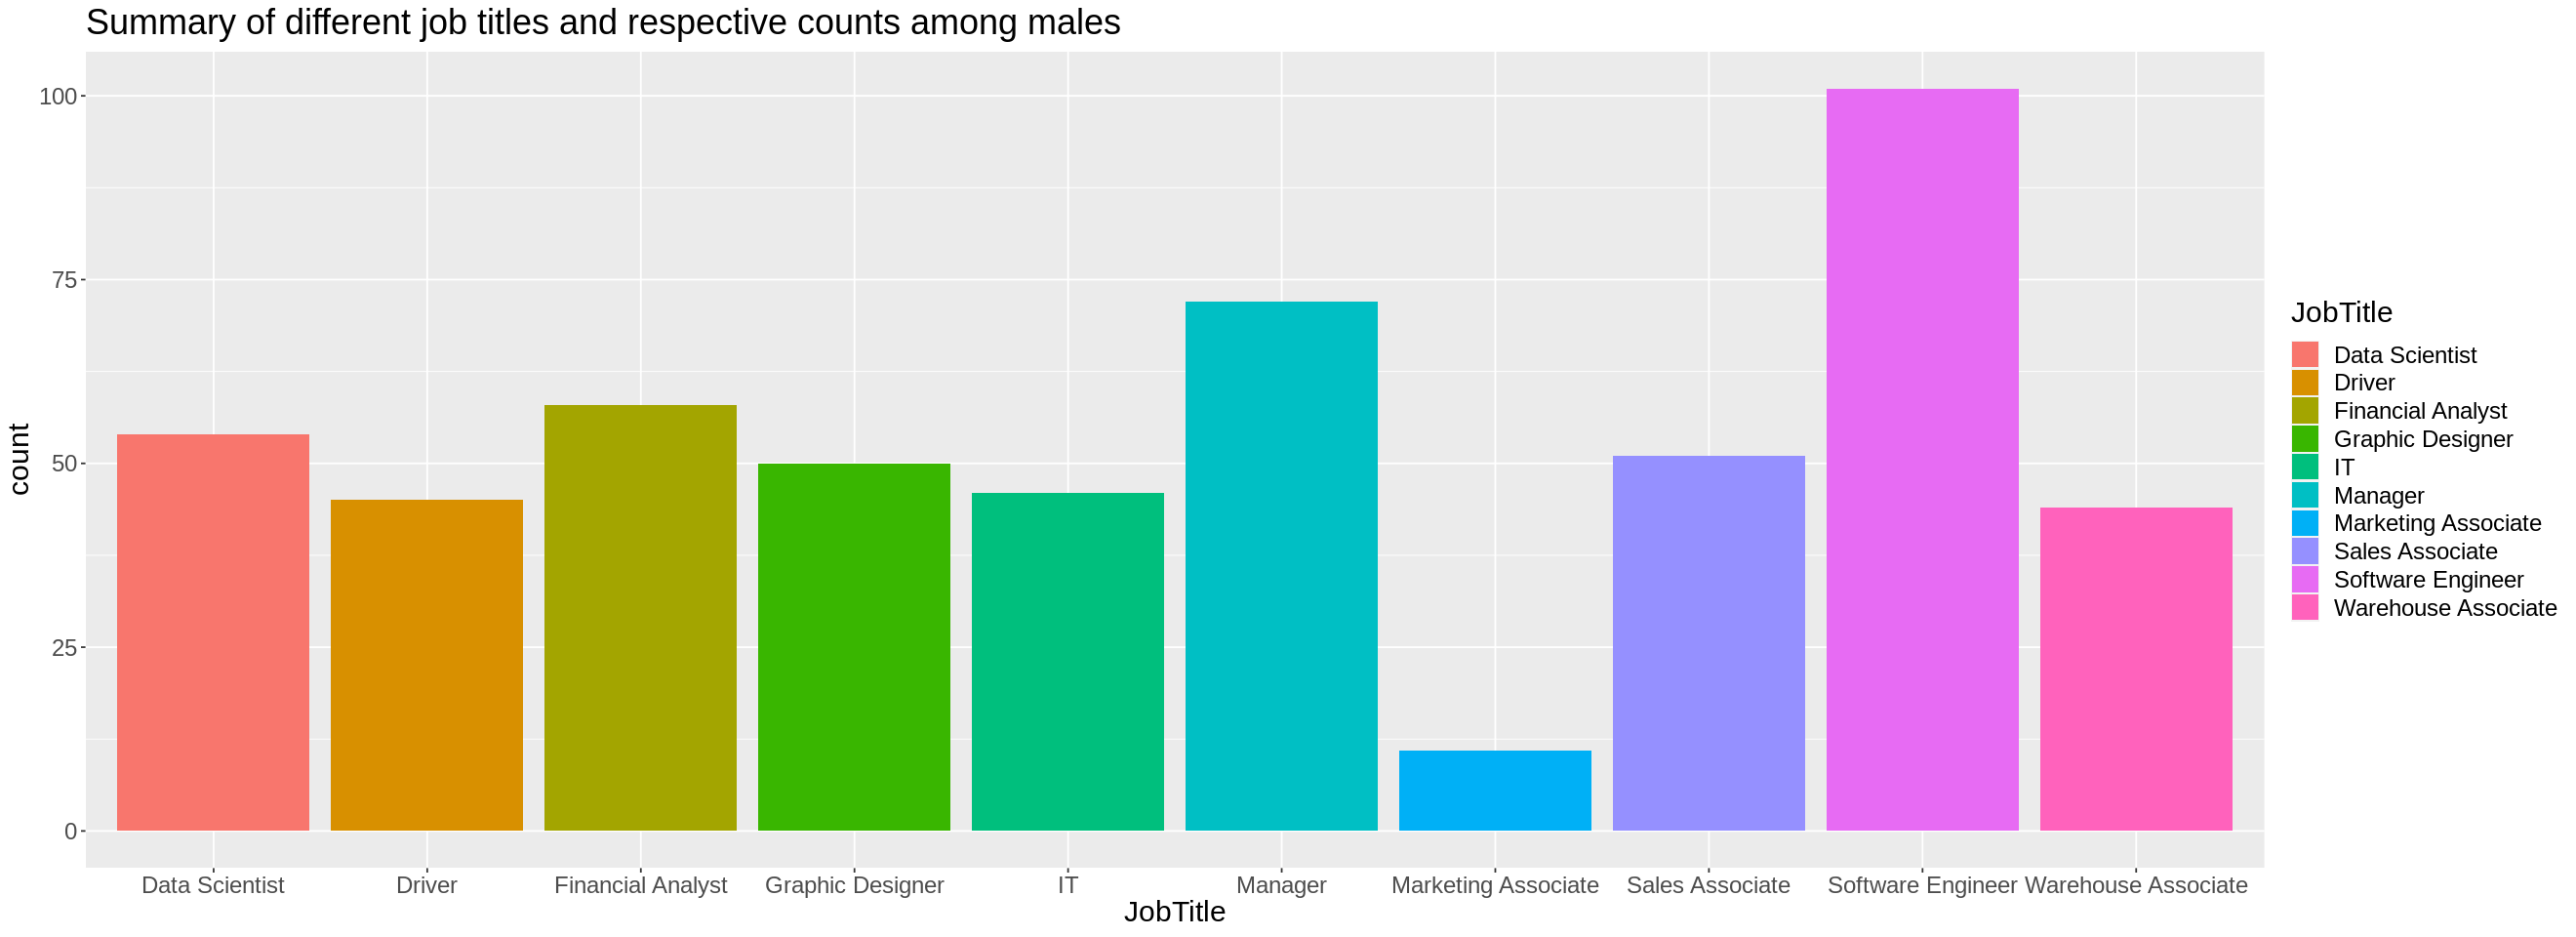

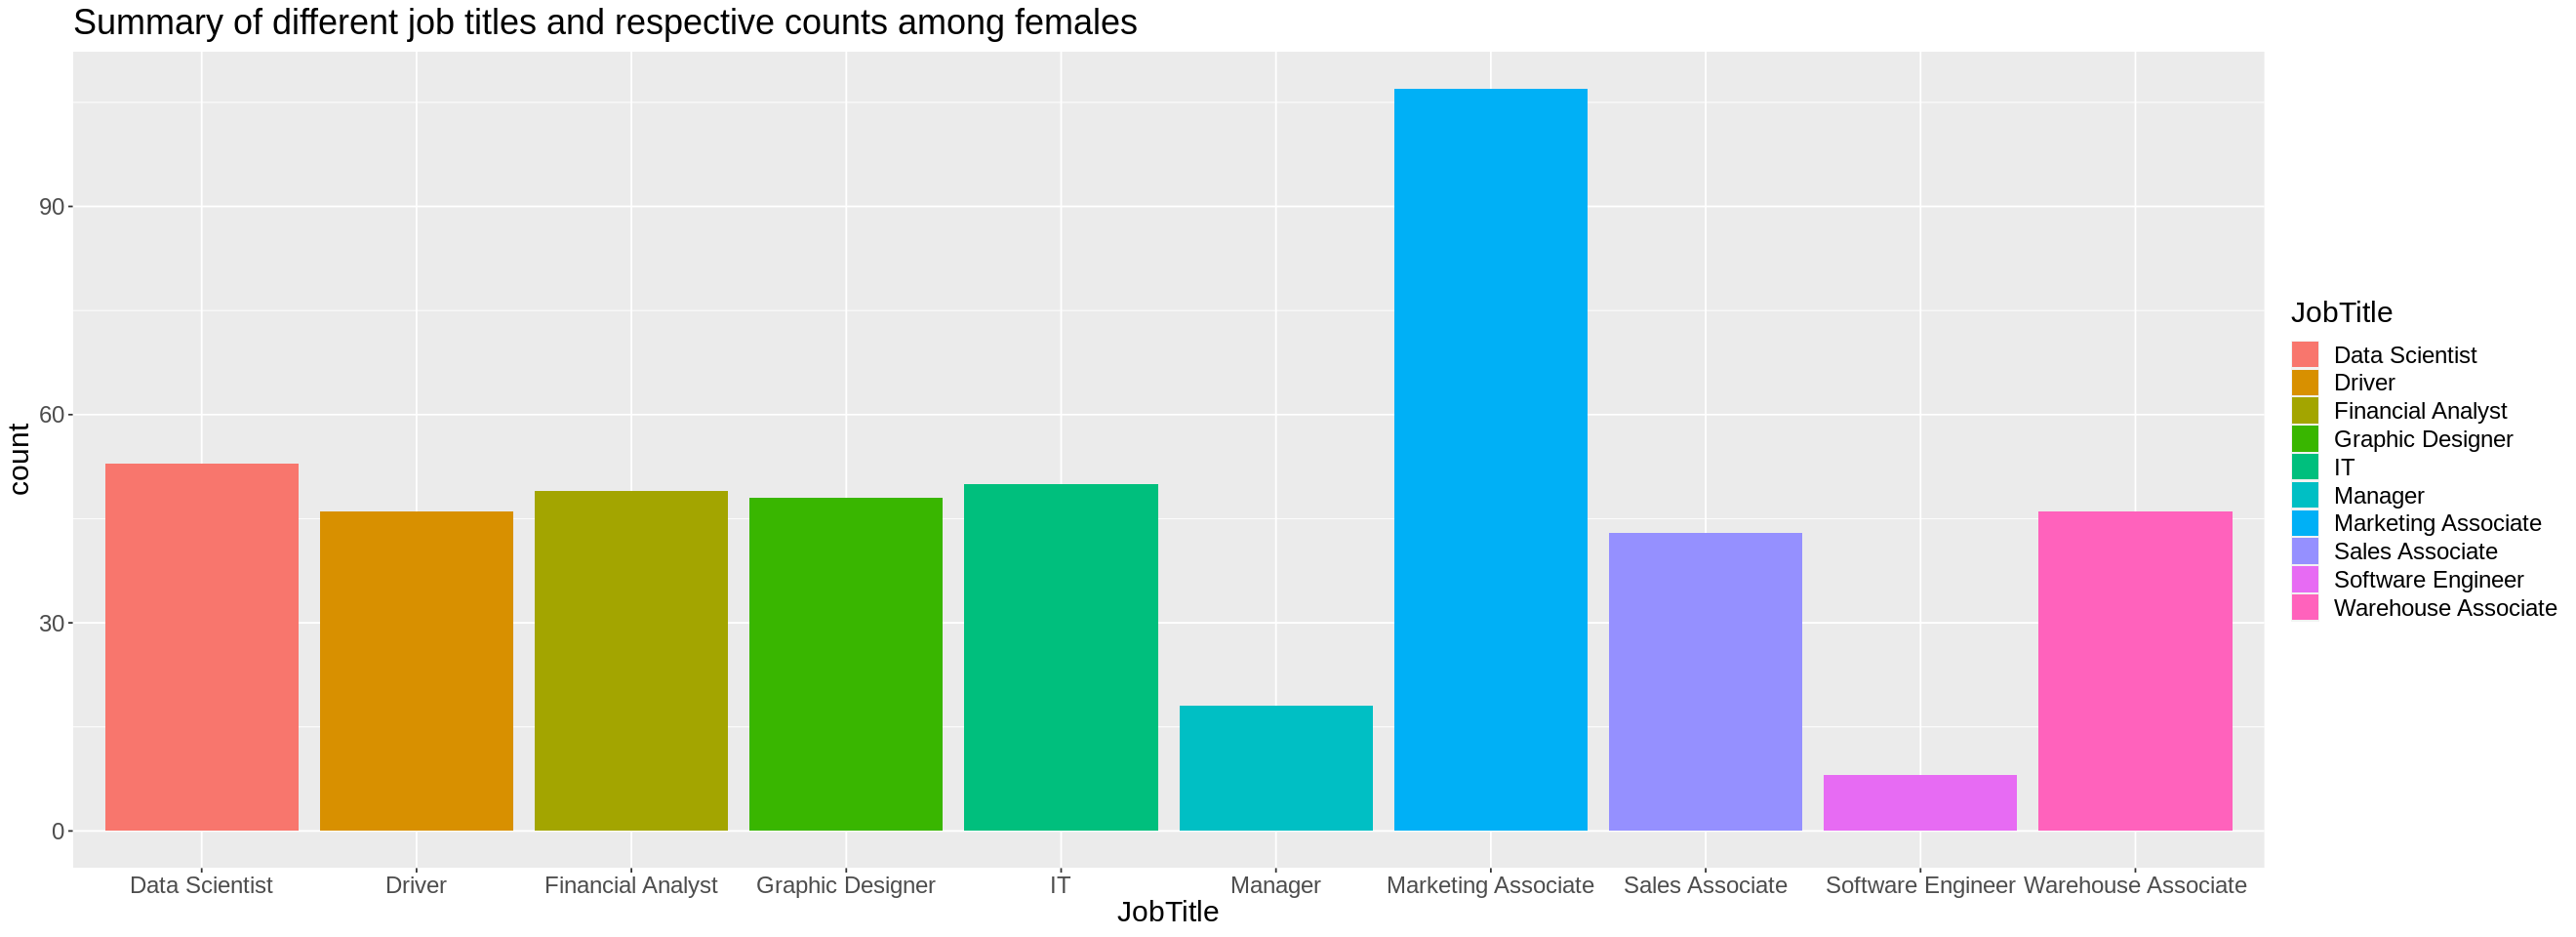

In [75]:
# helper function for making bar charts
MakeBarChart <- function(df, gender) {
    options(repr.plot.width = 22, repr.plot.height = 8)
    ggplot(data = df) +
       geom_bar(mapping = aes(x = JobTitle, fill = JobTitle)) +
       theme(text = element_text(size = 18)) +
       ggtitle(paste("Summary of different job titles and respective counts among", gender))
}

# barchart summary of JobTitles
MakeBarChart(male, "males")
MakeBarChart(female, "females")

From the barplots, it is evident that significantly fewer women assume manager or software engineer roles than men. Whereas in marketing, women make up the majority. This could contribute to the overall pay gap between genders, as positions in management and software engineering tend to have higher salaries.

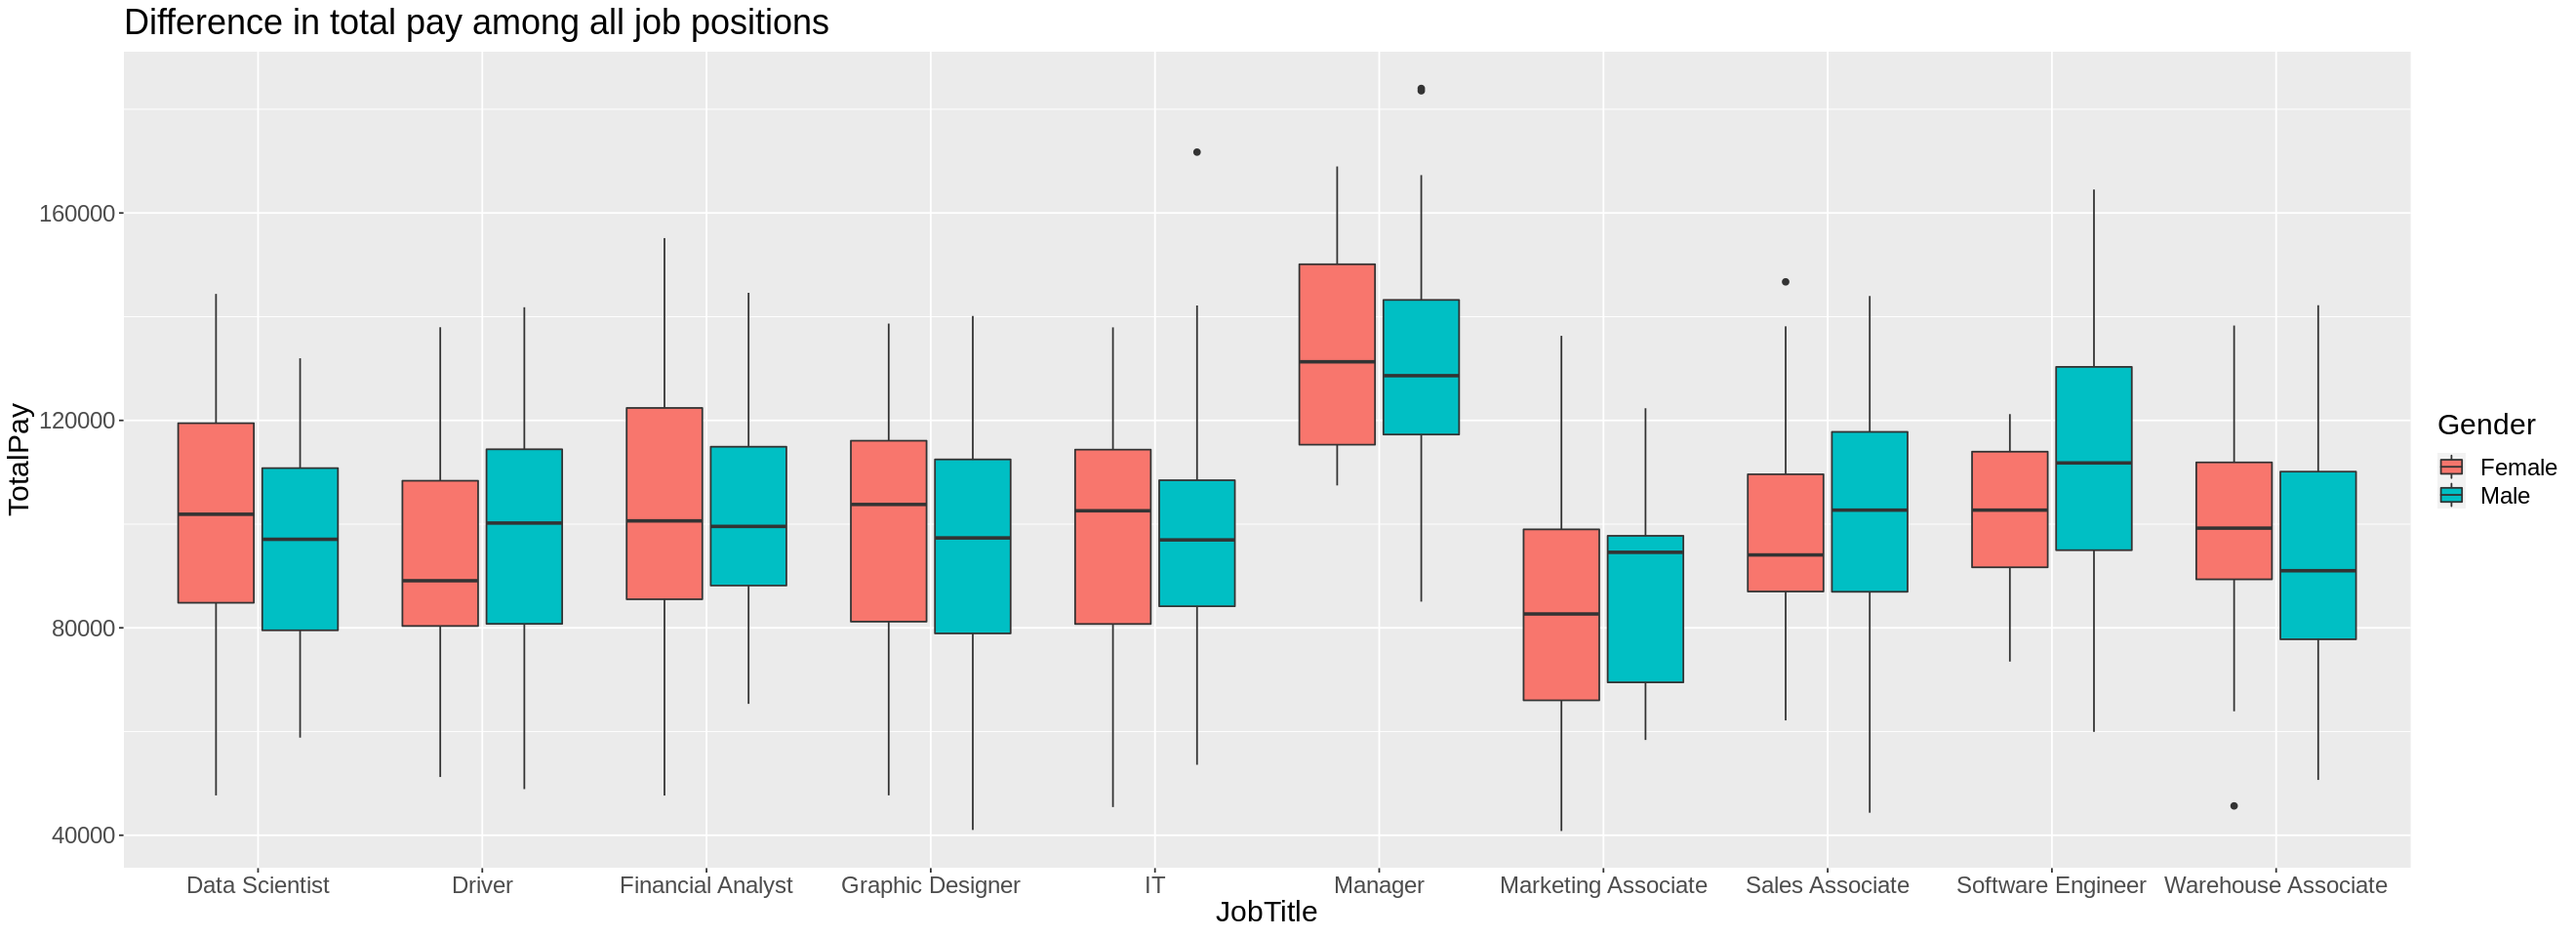

In [88]:
# Difference in total pay among the all job positions
ggplot(glassdoor, aes(x = JobTitle, y = TotalPay, fill = Gender)) +
    geom_boxplot() +
    ggtitle("Difference in total pay among all job positions") +
    theme(text = element_text(size = 18)) 

Is the gender pay gap mainly due to this "uneven distribution" of job positions, or are there significant pay differences between genders in every field? The plot above provides evidence that leans towards the former, as the pay ranges in other fields (except the three fields where males and females are disproportionate in numbers) appear reasonably close across genders. However, a more detailed analysis is needed.

## further analysis

The goal of the analysis is to explore whether (or the extent to which) gender is a significant factor for total pay. A linear regression model is built with TotalPay as the response variable. How much does the "Gender" term contribute to the model?

In [77]:
library(MASS)

To encode the level of salary in different fields, we assigned each job title into a group based on preliminary analysis above (previous boxplot):  
- "Manager" and "Software Engineer" as H (High paid)
- "Marketing Associate" as L (Low paid)
- Other positions as M (Medium paid)

In [78]:
# create a new variable: JobGroup
glassdoor$JobGroup <- glassdoor$JobTitle
glassdoor <- glassdoor %>% mutate(
                              JobGroup = case_when(
                                  JobGroup %in% c("Manager", "Software Engineer")  ~ "H",
                                  JobGroup == "Marketing Associate" ~ "L",
                                  TRUE ~ "M")                              
                              )
glassdoor$JobGroup <- as.factor(glassdoor$JobGroup)

Build a linear regression model with all relevant variables as covariates, denoted as the full model.

In [79]:
full <- lm(TotalPay ~ JobGroup + Gender + Age + PerfEval + Education + Seniority, data = glassdoor)
summary(full)


Call:
lm(formula = TotalPay ~ JobGroup + Gender + Age + PerfEval + 
    Education + Seniority, data = glassdoor)

Residuals:
   Min     1Q Median     3Q    Max 
-43710  -7538    546   7760  34652 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           58025.56    1929.37  30.075  < 2e-16 ***
JobGroupL            -38753.98    1451.86 -26.693  < 2e-16 ***
JobGroupM            -22671.62     957.93 -23.667  < 2e-16 ***
GenderMale              -21.97     796.73  -0.028  0.97800    
Age                     960.01      25.04  38.345  < 2e-16 ***
PerfEval2              1142.53    1145.63   0.997  0.31887    
PerfEval3              2197.60    1148.46   1.914  0.05597 .  
PerfEval4              3652.40    1126.93   3.241  0.00123 ** 
PerfEval5              3712.84    1129.29   3.288  0.00105 ** 
EducationHigh School  -1593.16    1008.15  -1.580  0.11437    
EducationMasters       4318.21    1015.05   4.254 2.30e-05 ***
EducationPhD           6201.68 

The full model has a R-squared value of approximately 0.80, meaning about 80% of variation in TotalPay can be explained by the model. It is notable that the gender term appears not significant (a large P value and no significant code). Furthermore, based on the stepwise AIC (Akaike information criterion) below, the optimal model discards the gender term.

In [80]:
# find the optimal model (the one with most predictive power) using AIC 
stepAIC(full, scope = list(lower = ~ 1, upper = full), direction = "backward")

Start:  AIC=18674.97
TotalPay ~ JobGroup + Gender + Age + PerfEval + Education + Seniority

            Df  Sum of Sq        RSS   AIC
- Gender     1 9.6539e+04 1.2489e+11 18673
<none>                    1.2489e+11 18675
- PerfEval   4 2.0519e+09 1.2694e+11 18683
- Education  3 9.8174e+09 1.3471e+11 18745
- JobGroup   2 1.0261e+11 2.2750e+11 19271
- Age        1 1.8662e+11 3.1151e+11 19587
- Seniority  4 1.8854e+11 3.1343e+11 19587

Step:  AIC=18672.97
TotalPay ~ JobGroup + Age + PerfEval + Education + Seniority

            Df  Sum of Sq        RSS   AIC
<none>                    1.2489e+11 18673
- PerfEval   4 2.0587e+09 1.2695e+11 18681
- Education  3 9.8355e+09 1.3473e+11 18743
- JobGroup   2 1.2479e+11 2.4968e+11 19362
- Seniority  4 1.8859e+11 3.1348e+11 19585
- Age        1 1.8678e+11 3.1168e+11 19586



Call:
lm(formula = TotalPay ~ JobGroup + Age + PerfEval + Education + 
    Seniority, data = glassdoor)

Coefficients:
         (Intercept)             JobGroupL             JobGroupM  
               58007                -38737                -22664  
                 Age             PerfEval2             PerfEval3  
                 960                  1141                  2195  
           PerfEval4             PerfEval5  EducationHigh School  
                3651                  3710                 -1594  
    EducationMasters          EducationPhD            Seniority2  
                4316                  6201                  8869  
          Seniority3            Seniority4            Seniority5  
               18648                 29472                 39114  


In [81]:
# summary of the optimal model (essentially full model neglecting the gender term)
optimal <- lm(TotalPay ~ JobGroup + Age + PerfEval + Education + Seniority, data = glassdoor)
summary(optimal)


Call:
lm(formula = TotalPay ~ JobGroup + Age + PerfEval + Education + 
    Seniority, data = glassdoor)

Residuals:
   Min     1Q Median     3Q    Max 
-43714  -7543    551   7759  34648 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           58007.23    1810.36  32.042  < 2e-16 ***
JobGroupL            -38736.98    1313.85 -29.484  < 2e-16 ***
JobGroupM            -22663.62     912.44 -24.839  < 2e-16 ***
Age                     960.03      25.01  38.381  < 2e-16 ***
PerfEval2              1141.16    1143.98   0.998  0.31875    
PerfEval3              2195.28    1144.80   1.918  0.05545 .  
PerfEval4              3651.22    1125.55   3.244  0.00122 ** 
PerfEval5              3710.22    1124.74   3.299  0.00101 ** 
EducationHigh School  -1593.66    1007.48  -1.582  0.11401    
EducationMasters       4316.49    1012.62   4.263 2.21e-05 ***
EducationPhD           6200.67    1032.22   6.007 2.65e-09 ***
Seniority2             8868.94    1125.2

Comparing the full model and the optimal model (essentially full model without gender term), the R-sqaured value and Residual standard error both vary marginally, which indicates a weak contribution of the gender term towards the model. Formally, we can compute the proportionate reduction of error (PRE):

In [82]:
# proportionate reduction of error
(summary(full)$sigma - summary(optimal)$sigma)/summary(optimal)$sigma

[1] 0.0005076144

The above proportionate reduction of error is very small, suggesting that the contribution of gender term itself is indeed insignificant. Hence, it can be concluded that the overall pay gap can be largely attributed to the disproportionate number of male and female enties in those three job positions:
- There are more males in high-paid job group (manager or software enginner) and more females in low-paid job group (marketing associate)
- If we plot only from the medium pay group, the gap is no longer significant:
 

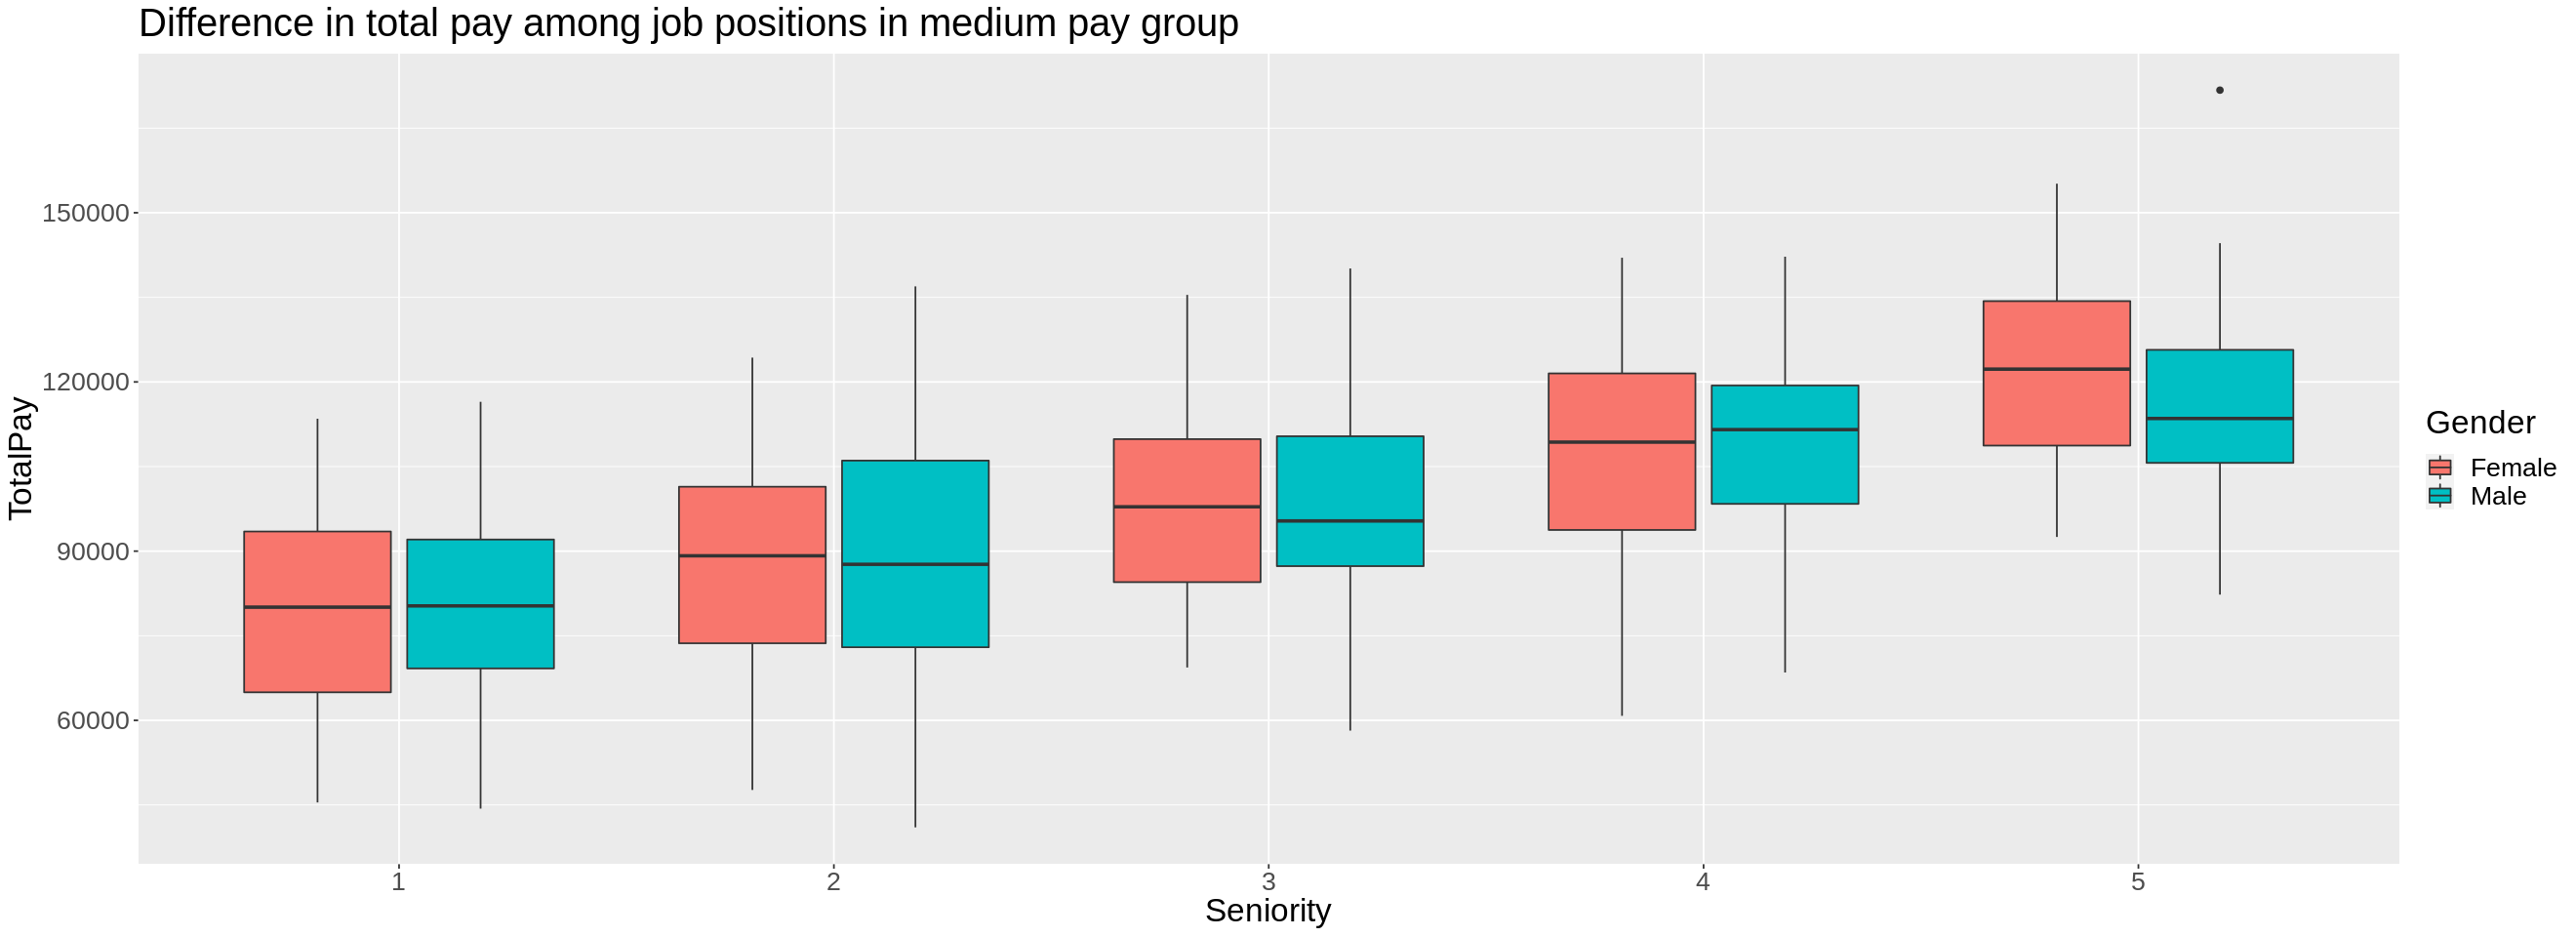

In [84]:
sub <- glassdoor %>%
       filter(JobGroup == "M")
ggplot(sub, aes(x = Seniority, y = TotalPay, fill = Gender)) +
    geom_boxplot() +
    ggtitle("Difference in total pay among job positions in medium pay group") +
    theme(text = element_text(size = 20)) 

## Conclusion

Overall gender pay gap from this Glassdoor profile dataset is identified, and is found to be mostly a result of uneven distribution of males and females in certain fields. Although there could be some sampling bias for it to be unevenly distributed, this result does agree with our current life situations.  
In particular, women are underrepresented in software engineering, and more broadly,in STEM positions. Women are also less likely to assume management roles, even with the same level of seniority and performance. These are some of the issues that need to be tackled for working towards gender equality.